
# **Failed Banks EDA**
>### Exploring the correlations and trends in the FDIC Failed Bank data) 
#### *data obtained from FDIC bank records API and the FDIC Bank List, combined and cleaned with Big Query, see dataset for documented data manipulation steps.
## -----------------------------------------------------------------------------------------------------------------------
## **Imports**
### Importing the dataset and R packages. 




In [1]:
library(tidyverse)
library(ggplot2)
library(dplyr)
library(moments)
install.packages("viridisLite")
library(viridis)
list.files(path = "../input")
df <- read.csv("/kaggle/input/failed-banks-fdic-data/Failed_Bank_Dataset_2.csv")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: viridisLite



[1] "failed-banks-fdic-data"

## **Questions we seek to explore in the failed banks dataset:**

> * #### Total amount of bank failures and estimated losses per year since 2000
> * #### Bank failures and estimated losses by state 
> * #### Comparing the (deposits to assets ratio) to (esitmated loss to assets ratio)


## **Viewing the structure and quality of the data.**

In [2]:
str(df)

'data.frame':	566 obs. of  9 variables:
 $ Bank_Name            : chr  "First Republic Bank" "Signature Bank" "Silicon Valley Bank" "Almena State Bank" ...
 $ City                 : chr  "San Francisco" "New York" "Santa Clara" "Almena" ...
 $ State                : chr  "CA" "NY" "CA" "KS" ...
 $ Cert                 : int  59017 57053 24735 15426 16748 14361 18265 21111 58112 58317 ...
 $ Acquiring_Institution: chr  "JPMorgan Chase Bank, N.A." "Flagstar Bank, N.A." "First–Citizens Bank & Trust Company" "Equity Bank" ...
 $ Closing_Date         : chr  "2023-05-01" "2023-03-12" "2023-03-10" "2020-10-23" ...
 $ Estimated_Loss       : num  NA 2.40e+09 1.61e+10 1.63e+07 7.25e+06 ...
 $ Total_Assets         : num  2.13e+11 1.10e+11 2.09e+11 6.57e+07 1.37e+08 ...
 $ Total_Deposits       : num  1.76e+11 8.86e+10 1.75e+11 6.49e+07 1.34e+08 ...


In [3]:
na_count <- colSums(is.na(df))
print(na_count)
#removing the two N/A rows 
df_clean <- na.omit(df)
#adding a year column 
df_clean$Year <- substr(df_clean$Closing_Date, 0,4)

            Bank_Name                  City                 State 
                    0                     0                     0 
                 Cert Acquiring_Institution          Closing_Date 
                    0                     0                     0 
       Estimated_Loss          Total_Assets        Total_Deposits 
                    2                     0                     0 


### **Visualizing the distributions of the numeric columns with sqrt and log transformations**

Warning message:
“Removed 13 rows containing non-finite values (`stat_ydensity()`).”


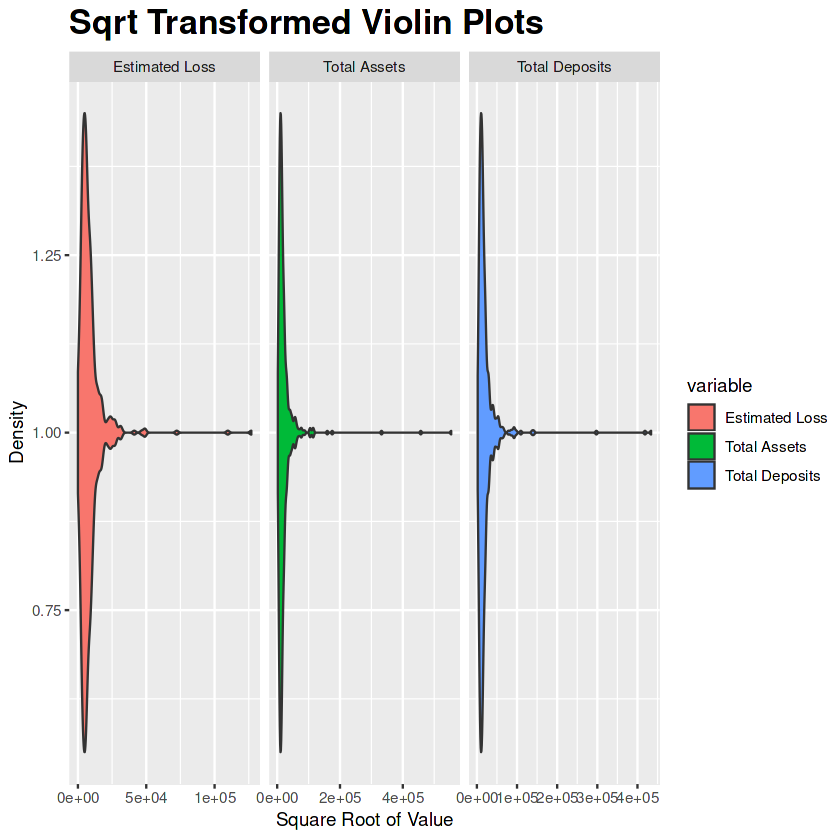

        Variable Skewness
1 Estimated Loss 14.53799
2   Total Assets 15.59010
3 Total Deposits 14.52115


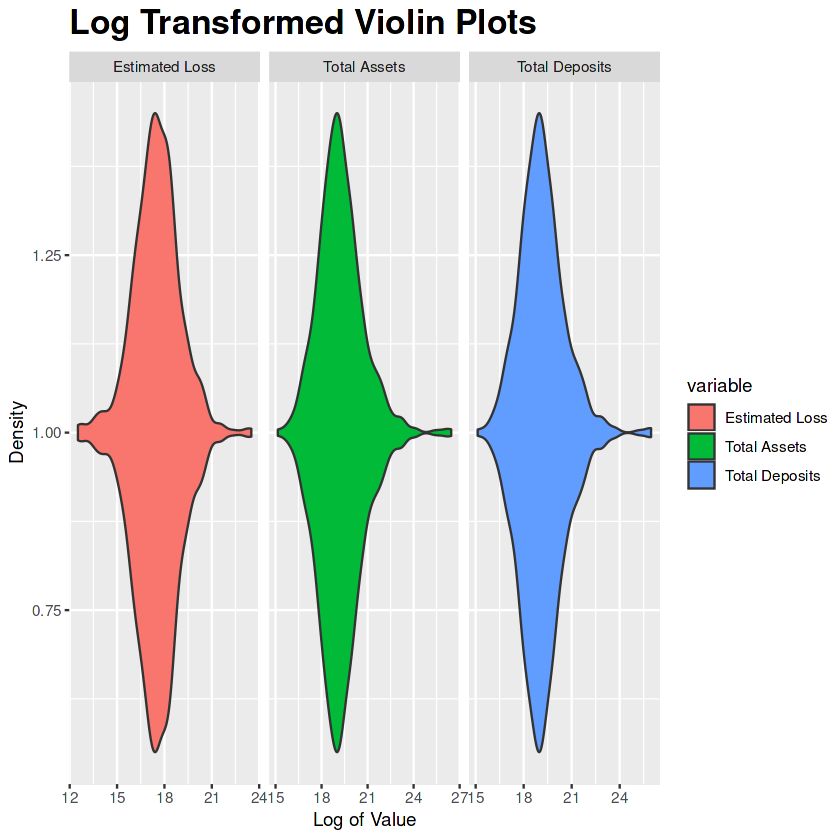

In [4]:
df_sqrt_stacked <- rbind(
  data.frame(value = sqrt(df_clean$Estimated_Loss), variable = "Estimated Loss"),
  data.frame(value = sqrt(df_clean$Total_Assets), variable = "Total Assets"),
  data.frame(value = sqrt(df_clean$Total_Deposits), variable = "Total Deposits"))

df_log_stacked <- rbind(
  data.frame(value = log(df_clean$Estimated_Loss), variable = "Estimated Loss"),
  data.frame(value = log(df_clean$Total_Assets), variable = "Total Assets"),
  data.frame(value = log(df_clean$Total_Deposits), variable = "Total Deposits")
)
# Create the stacked violin plot
ggplot(data = df_sqrt_stacked, aes(x = value, y = 1, fill = variable)) +
  geom_violin() +
  facet_wrap(~variable, scales = "free_x", ncol = 3) +
  labs(title = "Sqrt Transformed Violin Plots",
       x = "Square Root of Value",
       y = "Density",
       ) +
 theme(plot.title = element_text(size = 20, face = "bold"))
 
 ggplot(data = df_log_stacked, aes(x = value, y = 1,fill = variable)) +
  geom_violin() +
  facet_wrap(~variable, scales = "free_x", ncol = 3) +
  labs(title = "Log Transformed Violin Plots",
       x = "Log of Value",
       y = "Density") + 
  theme(plot.title = element_text(size = 20, face = "bold"))

df_skewness <- data.frame(
  Variable = c("Estimated Loss", "Total Assets", "Total Deposits"),
  Skewness = c(skewness(df_clean$Estimated_Loss), skewness(df_clean$Total_Assets), skewness(df_clean$Total_Deposits))
)
print(df_skewness)

### We can see that there is a general skewness to the right due to the presence of high-value outliers. Also, we have high values for skewness for each of the variables at around 14 to 15.

### **Plotting bank failures and estimated losses per year since 2000**

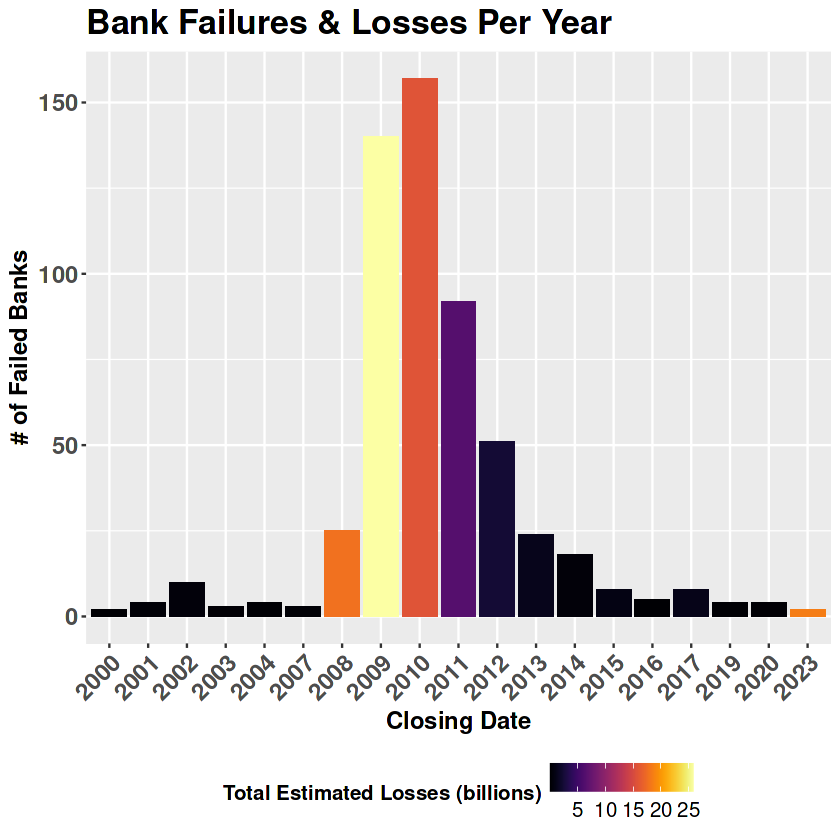

In [5]:
sum_by_year <- df_clean %>%
  group_by(Year) %>%
  summarise(Total_Estimated_Loss = sum(Estimated_Loss)/1000000000,
            Total_Fails = n_distinct(Cert))


ggplot(data = sum_by_year) +
  geom_col(mapping = aes(x = Year, y = Total_Fails, fill = Total_Estimated_Loss)) +
  scale_fill_viridis(option = "inferno") + 
  labs(title = "Bank Failures & Losses Per Year", x = "Closing Date", y = "# of Failed Banks", fill = "Total Estimated Losses (billions)  ") + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1,size = 14,face = "bold")) + 
  theme(axis.text.y = element_text(size = 14,face = "bold")) + 
  theme(legend.position = "bottom") +
  theme(plot.title = element_text(size = 20, face = "bold")) +  # Increase title size and font weight
  theme(axis.title.x = element_text(size = 14,face = "bold")) +  # Increase x-axis label size
  theme(axis.title.y = element_text(size = 14,face = "bold")) +  # Increase y-axis label size
  theme(legend.title = element_text(size = 12,face = "bold")) +  # Increase legend title size
  theme(legend.text = element_text(size = 12))

### From the chart, we can see that the majority of bank failures occurred during the 2008 housing bubble and then slowly declined since then. We can also see the severity of the bank failures in the total estimated unrecoverable losses for each year the banks failed. Just keep in mind that the losses do not represent the total amount of money lost in the economy, but only the amount unrecoverable from each closed bank.The US economy lost trillions in 2008. <br> <br> The losses represent the liabilities that the banks were not able to pay back after the liquidation of all the bank's assets and all the insured deposits have been paid by the Deposit Insurance Fund (DIF). From 1984 up until 2008, the deposit insurance limit was 100,000; since 2008, it has been raised to 250,000. Just a reminder to not keep all your eggs in one basket.<br> <br> Also, we can see that there is a large loss in 2023 and yet very few numbers of bank failures. This is due to the failure of Silicon Valley Bank in 2023, which is an estimated loss of about 16 billion. Keep in mind that these numbers are not adjusted for inflation. 

### **Bank failures and estimated losses by state**

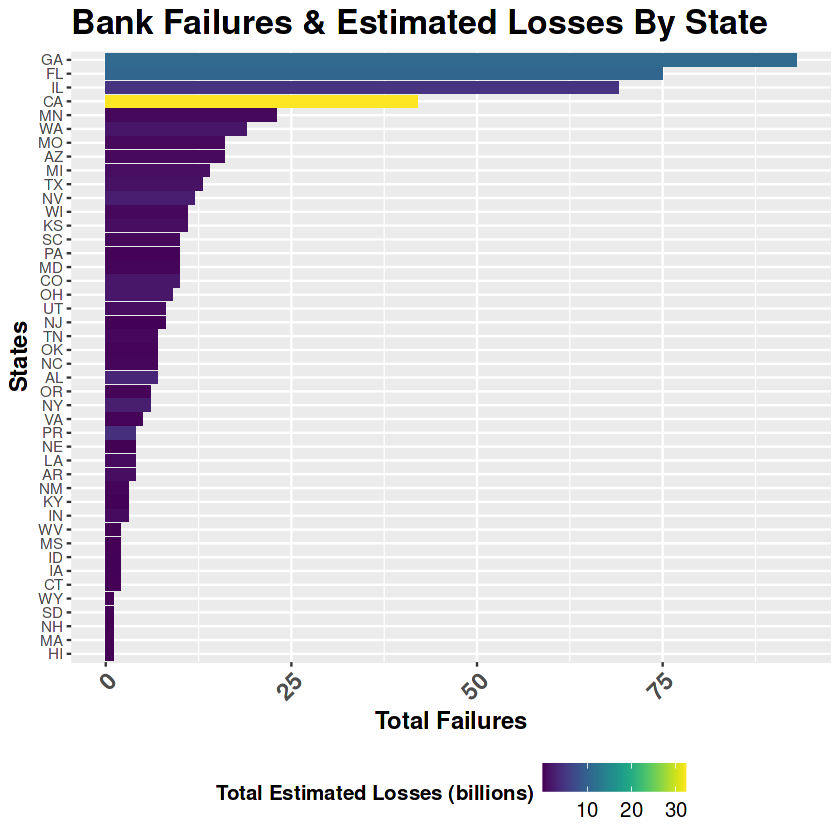

In [6]:
sum_by_state2 <- df_clean %>%
    group_by(State) %>%
    summarise(Total_Estimated_Loss = sum(Estimated_Loss)/1000000000,
            Total_Fails = n_distinct(Cert))
sum_by_state2$State <- reorder(sum_by_state2$State, sum_by_state2$Total_Fails)

ggplot(data = sum_by_state2) + 
  geom_col(mapping = aes(x = Total_Fails, y = State,fill = Total_Estimated_Loss)) +
  scale_fill_viridis() + 
  labs(title = "Bank Failures & Estimated Losses By State", x = "Total Failures", y = "States", fill = "Total Estimated Losses (billions)  ") + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1,size = 14,face = "bold")) +
  theme(legend.position = "bottom") +
  theme(plot.title = element_text(size = 20, face = "bold")) +  # Increase title size and font weight
  theme(axis.title.x = element_text(size = 14,face = "bold")) +  # Increase x-axis label size
  theme(axis.title.y = element_text(size = 14,face = "bold")) +  # Increase y-axis label size
  theme(legend.title = element_text(size = 12,face = "bold")) +  # Increase legend title size
  theme(legend.text = element_text(size = 12))

### We can see that Georgia has by far the most bank failures, followed by Florida. In terms of estimated losses, California tops the list with close to 30 billion in losses. The data appears to show an exponential drop in the total number of failures by state as we go down the chart, but the estimated losses seem to be more or less within a consistent range. This signals more dramatic single-institution failures as compared to many small bank failures.



### **Viewing Ratios**

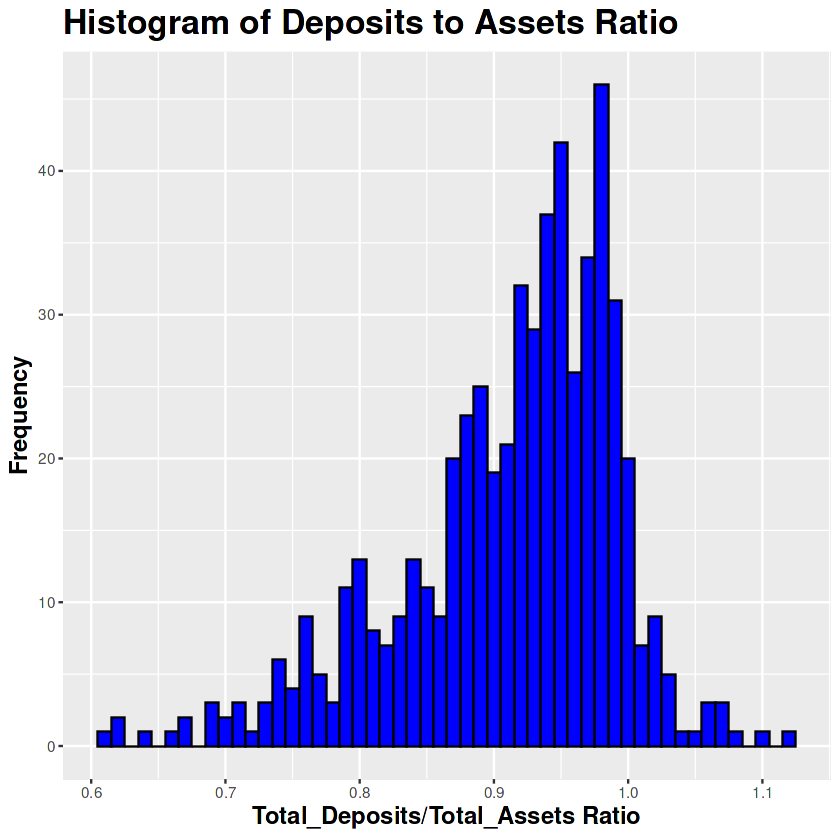

In [7]:
ggplot(data = df_clean, aes(x = (Total_Deposits / Total_Assets))) +
  geom_histogram(binwidth = 0.01, color = "black", fill = "blue") +
  labs(x = "Total_Deposits/Total_Assets Ratio", y = "Frequency", title = "Histogram of Deposits to Assets Ratio") + 
  theme(plot.title = element_text(size = 20, face = "bold")) + 
  theme(axis.title.x = element_text(size = 14, face = "bold")) + 
  theme(axis.title.y = element_text(size = 14, face = "bold")) 

### From this graph, we can see that the deposits to assets ratio increases exponentially until we get to a 1:1 ratio. Banks fail for many different reasons, and there are also different types of banks. Therefore, the ratio will vary between the failed banks.

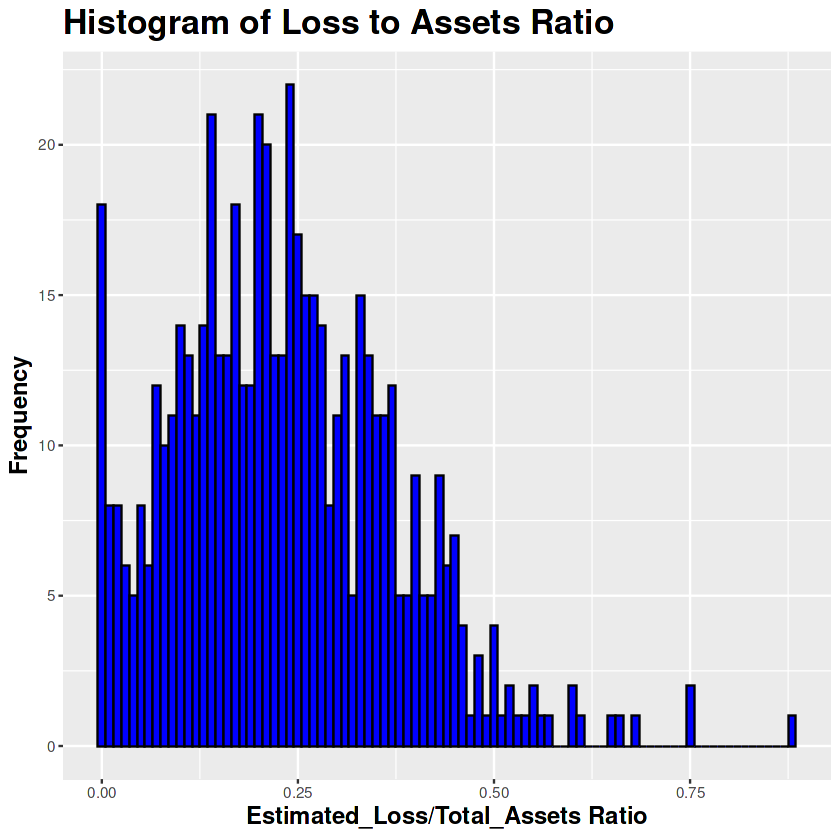

In [8]:
ggplot(data = df_clean, aes(x = (Estimated_Loss / Total_Assets))) +
  geom_histogram(binwidth = 0.01, color = "black", fill = "blue") +
  labs(x = "Estimated_Loss/Total_Assets Ratio", y = "Frequency", title = "Histogram of Loss to Assets Ratio") + 
  theme(plot.title = element_text(size = 20, face = "bold")) + 
  theme(axis.title.x = element_text(size = 14, face = "bold")) + 
  theme(axis.title.y = element_text(size = 14, face = "bold")) 

### Here we see the percentage of losses with respect to assets, with a mean centered at around 25%.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


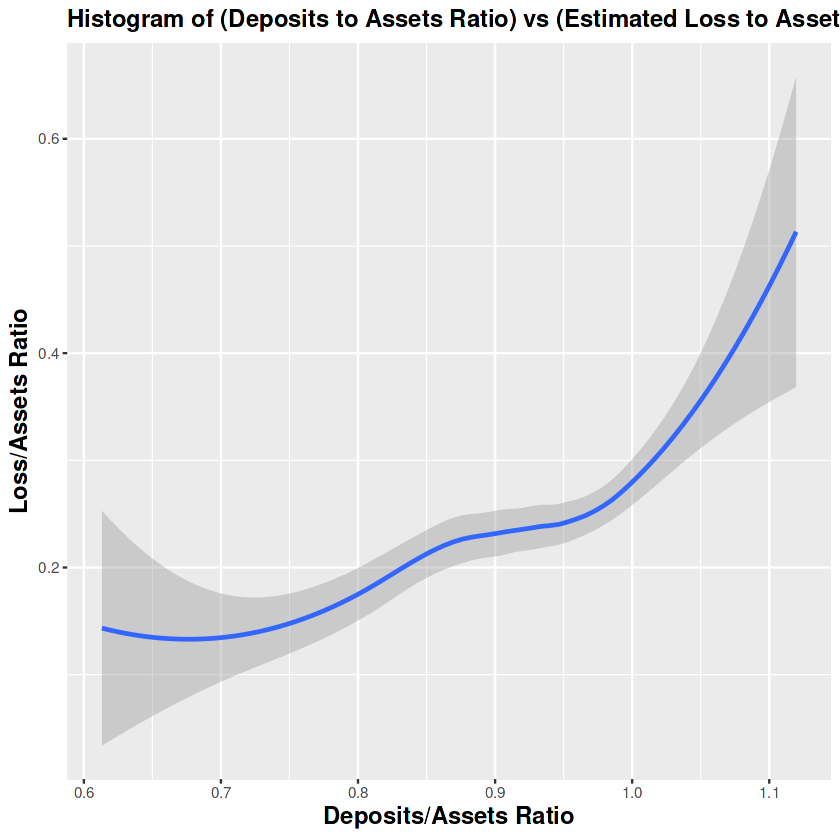

In [9]:
ggplot(data = df_clean) +
  geom_smooth(mapping = aes(x = (Total_Deposits / Total_Assets),y = (Estimated_Loss/Total_Assets))) +
  labs(x = "Deposits/Assets Ratio", y = "Loss/Assets Ratio", title = "Histogram of (Deposits to Assets Ratio) vs (Estimated Loss to Assets Ratio)") + 
  theme(plot.title = element_text(size = 14, face = "bold")) + 
  theme(axis.title.x = element_text(size = 14, face = "bold")) + 
  theme(axis.title.y = element_text(size = 14, face = "bold")) 


### Here we can see a clear upward trend in the data, with the loss/assets ratio increasing as the deposits/assets ratio increases. This indicates that failed banks which had a larger proportion of deposits to total assets suffered a larger percentage loss.